In [1]:
#Pairs Trading vs PCA

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

#plt.style.use('seaborn-darkgrid')

In [2]:
#Stock list for PCA
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSLA', 'NFLX', 'INTC', 'AMD']

data = yf.download(tickers, start='2019-01-01', end='2024-12-31')['Close']

data = data.dropna()
data.head(10)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  9 of 9 completed


Ticker,AAPL,AMD,AMZN,GOOG,INTC,META,MSFT,NFLX,TSLA
Date,,,,,,,,,
2019-01-02,37.617855,18.830000,76.956497,52.045982,40.518055,135.043533,94.945511,267.660004,20.674667
2019-01-03,33.870834,17.049999,75.014000,50.563507,38.289040,131.122025,91.452667,271.200012,20.024000
2019-01-04,35.316757,19.000000,78.769501,53.283127,40.638538,137.302887,95.706055,297.570007,21.179333
2019-01-07,35.238159,20.570000,81.475502,53.167671,40.827873,137.402420,95.828110,315.339996,22.330667
2019-01-08,35.909901,20.750000,82.829002,53.560310,41.086048,141.861420,96.522926,320.269989,22.356667
2019-01-09,36.519707,20.190001,82.971001,53.479694,41.318417,143.553436,97.903160,319.959991,22.568666
2019-01-10,36.636433,19.740000,82.810997,53.264217,41.791767,143.523575,97.274063,324.660004,22.997999
2019-01-11,36.276737,20.270000,82.028000,52.610317,42.110195,143.125458,96.522926,337.589996,23.150667
2019-01-14,35.731243,20.230000,80.860497,51.988262,41.611031,144.707993,95.818733,332.940002,22.293333


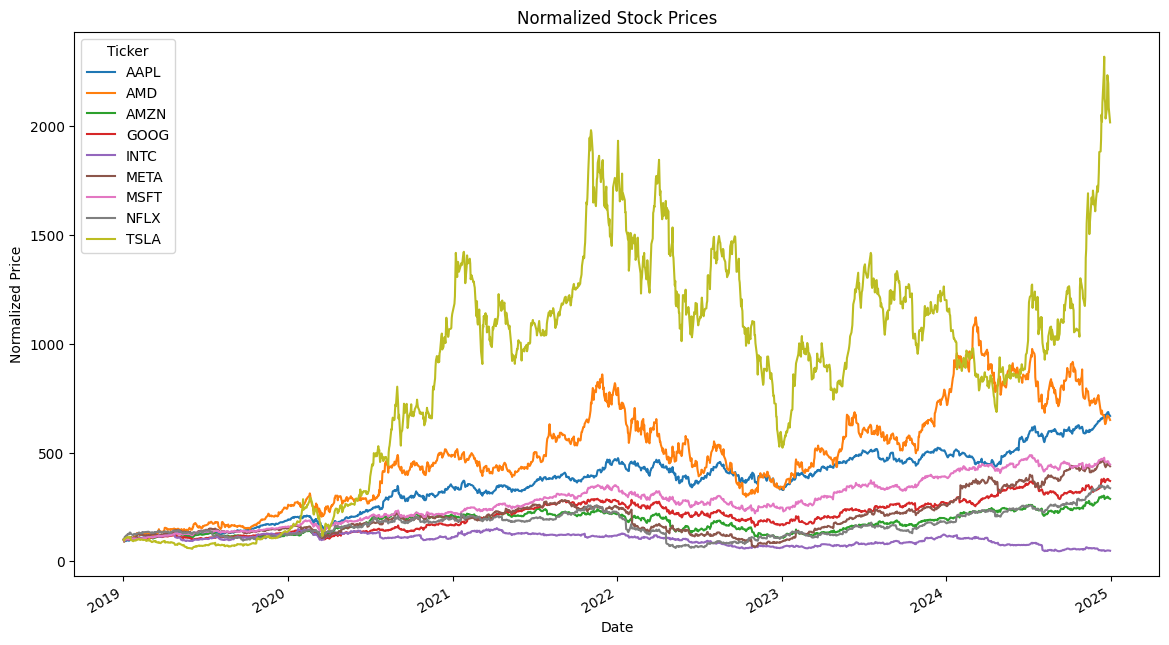

In [3]:
#Lets normalize and plot them

normalized_prices = data / data.iloc[0] * 100

normalized_prices.plot(figsize=(14,8))
plt.title("Normalized Stock Prices")
plt.ylabel("Normalized Price")
plt.show()

In [4]:
log_returns = np.log(data / data.shift(1)).dropna()
log_returns.head()

Ticker,AAPL,AMD,AMZN,GOOG,INTC,META,MSFT,NFLX,TSLA
Date,,,,,,,,,
2019-01-03,-0.104925,-0.099301,-0.025566,-0.028897,-0.056584,-0.029469,-0.037482,0.013139,-0.031978
2019-01-04,0.041803,0.108289,0.048851,0.052390,0.059553,0.046061,0.045460,0.092793,0.056094
2019-01-07,-0.002228,0.079395,0.033777,-0.002169,0.004648,0.000725,0.001274,0.058002,0.052935
2019-01-08,0.018883,0.008713,0.016476,0.007358,0.006304,0.031937,0.007224,0.015513,0.001164
2019-01-09,0.016839,-0.027359,0.001713,-0.001506,0.005640,0.011857,0.014198,-0.000968,0.009438


In [5]:
#Strategy 1: Pairs Trading

In [6]:
tickers = ['AAPL', 'MSFT']
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Close']
data = data.dropna()

[*********************100%***********************]  2 of 2 completed


In [7]:
score, pvalue, _ = coint(data['AAPL'], data['MSFT'])
print(f"Cointegration test p-value: {pvalue:4f}")

Cointegration test p-value: 0.220618


In [8]:
x = sm.add_constant(data['MSFT'])
model = sm.OLS(data['AAPL'], x).fit()
hedge_ratio = model.params['MSFT']
print(f"Hedge Ratio: {hedge_ratio:.4f}")

Hedge Ratio: 0.5700


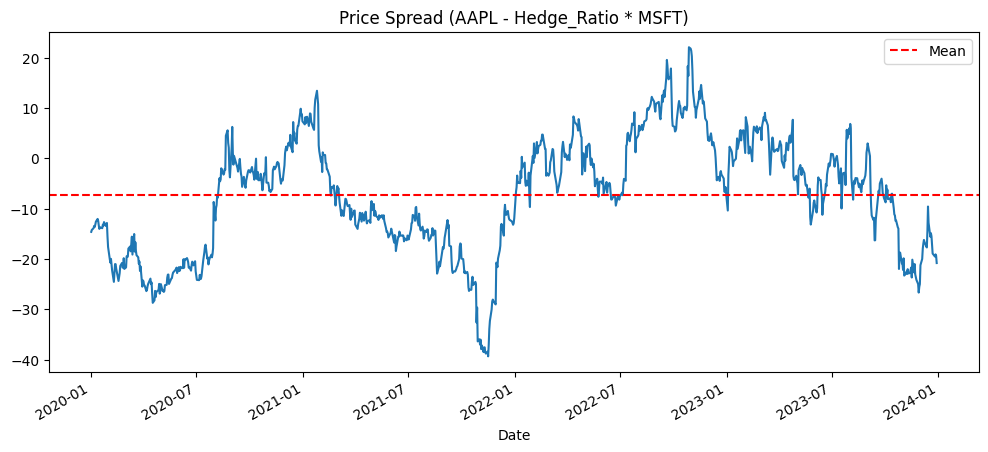

In [9]:
spread = data['AAPL'] - hedge_ratio * data['MSFT']
spread.plot(title='Price Spread (AAPL - Hedge_Ratio * MSFT)', figsize=(12, 5))
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.show()

In [10]:
#mean rolling and Std
spread_mean = spread.rolling(window=30).mean()
spread_std = spread.rolling(window=30).std()

# Calculate z-score
z_score = (spread - spread_mean) / spread_std

# Create signal column
signals = pd.DataFrame(index=data.index)
signals['z_score'] = z_score

In [11]:
signals['long_spread'] = (z_score < -1).astype(int)  # Buy spread: Long AAPL, Short MSFT
signals['short_spread'] = (z_score > 1).astype(int)  # Sell spread: Short AAPL, Long MSFT
signals['exit'] = ((z_score > -0.5) & (z_score < 0.5)).astype(int)  # Exit condition

In [12]:
print(signals.tail())

             z_score  long_spread  short_spread  exit
Date                                                 
2023-12-22  0.172987            0             0     1
2023-12-26  0.005565            0             0     1
2023-12-27  0.080637            0             0     1
2023-12-28 -0.004575            0             0     1
2023-12-29 -0.374050            0             0     1


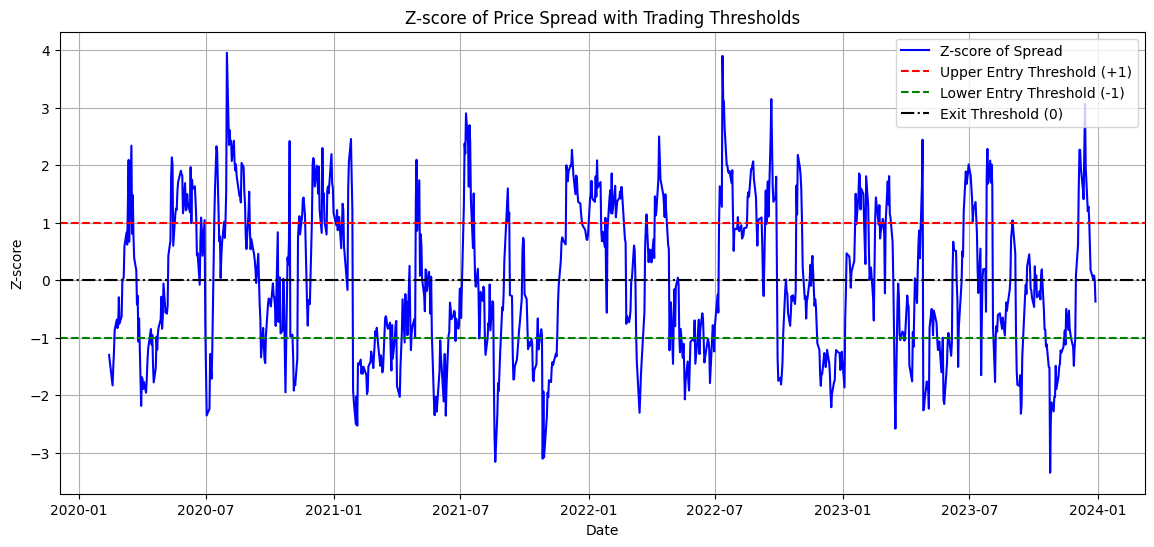

In [13]:
#We visualize z-scores

# Define thresholds
entry_threshold = 1.0
exit_threshold = 0.0

# Plot z-score with thresholds
plt.figure(figsize=(14,6))
plt.plot(signals.index, signals['z_score'], label='Z-score of Spread', color='blue')
plt.axhline(entry_threshold, color='red', linestyle='--', label='Upper Entry Threshold (+1)')
plt.axhline(-entry_threshold, color='green', linestyle='--', label='Lower Entry Threshold (-1)')
plt.axhline(exit_threshold, color='black', linestyle='-.', label='Exit Threshold (0)')
plt.title('Z-score of Price Spread with Trading Thresholds')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
#Backtesting Pairs Trading

positions = pd.DataFrame(index=signals.index)
returns = data[['AAPL', 'MSFT']].pct_change()

positions['long'] = ((signals['z_score'] < -entry_threshold) & 
                     (signals['z_score'].shift() >= -entry_threshold)).astype(int)
positions['short'] = ((signals['z_score'] > entry_threshold) & 
                      (signals['z_score'].shift() <= entry_threshold)).astype(int)
positions['exit'] = (signals['z_score'].abs() < exit_threshold).astype(int)

# Now maintain state
positions['position'] = 0
positions.loc[positions['long'] == 1, 'position'] = 1
positions.loc[positions['short'] == 1, 'position'] = -1
positions['position'] = positions['position'].replace(0, np.nan).ffill()
positions.loc[positions['exit'] == 1, 'position'] = 0  # Flat on exit

# Shift to avoid lookahead
positions['position'] = positions['position'].shift()

# Strategy return
positions['strategy'] = positions['position'] * (returns['AAPL'] - returns['MSFT'])

# Cumulative
positions['cumulative'] = (1 + positions['strategy']).cumprod()


#print("Total long trades:", positions['long'].sum())
#print("Total short trades:", positions['short'].sum())
#print("Z-score range:", signals['z_score'].min(), "to", signals['z_score'].max())

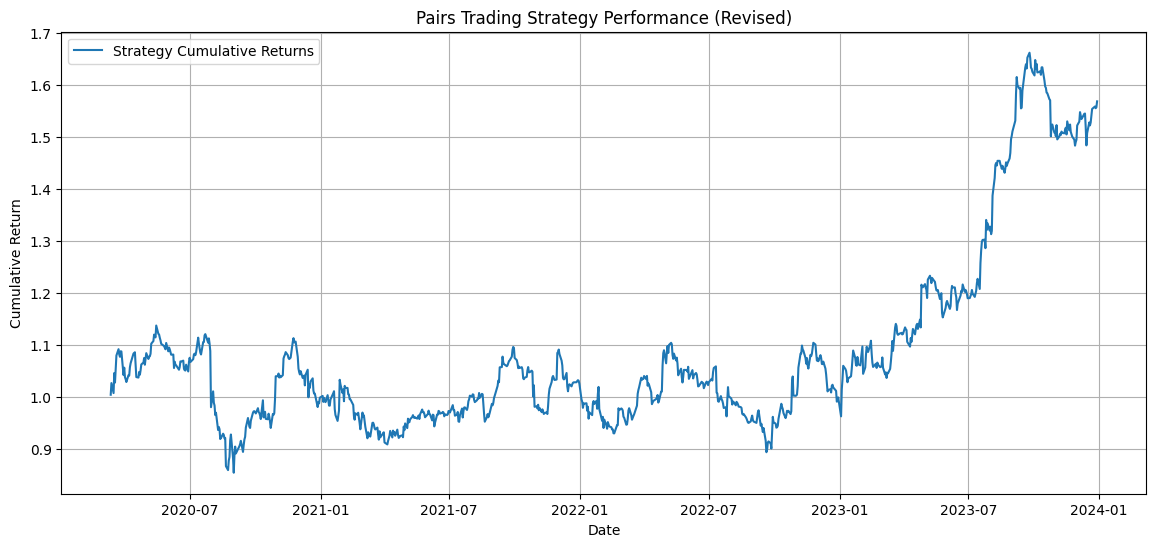

In [15]:
plt.figure(figsize=(14,6))
plt.plot(positions.index, positions['cumulative'], label='Strategy Cumulative Returns')
plt.title('Pairs Trading Strategy Performance (Revised)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.show()


In [16]:
# Daily strategy returns
strategy_returns = positions['strategy']

# Total Return
total_return = positions['cumulative'].iloc[-1] - 1

# Annualized Return
annual_return = strategy_returns.mean() * 252

# Annualized Volatility
annual_volatility = strategy_returns.std() * np.sqrt(252)

# Sharpe Ratio (assuming 0% risk-free rate)
sharpe_ratio = annual_return / annual_volatility

# Max Drawdown
cumulative = positions['cumulative']
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Print results
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annual_return:.2%}")
print(f"Annualized Volatility: {annual_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")


Total Return: 56.81%
Annualized Return: 14.28%
Annualized Volatility: 22.13%
Sharpe Ratio: 0.65
Maximum Drawdown: -24.89%


In [17]:
#Saving the cumulative code

# Save cumulative returns from Pairs Trading
cumulative_returns_pairs = positions['cumulative'].copy()


In [18]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Assume 'data' contains price data for AAPL and MSFT
stock1 = data['AAPL']
stock2 = data['MSFT']

# Drop missing values (important if any NaNs exist)
combined = pd.concat([stock1, stock2], axis=1).dropna()
stock1 = combined['AAPL']
stock2 = combined['MSFT']

# Regress AAPL on MSFT to get hedge ratio (beta)
X = sm.add_constant(stock2)
model = sm.OLS(stock1, X).fit()
beta = model.params[1]

# Now calculate spread and z-score
spread = stock1 - beta * stock2
zscore = (spread - spread.mean()) / spread.std()

# Generate signal
positions = pd.DataFrame(index=zscore.index)
positions['signal'] = 0
positions.loc[zscore > 1, 'signal'] = -1  # short spread
positions.loc[zscore < -1, 'signal'] = 1  # long spread
positions['signal'] = positions['signal'].shift()  # lag to avoid lookahead


C:\Users\anshr\AppData\Local\Temp\ipykernel_17812\2531838462.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


In [19]:
#Strategy 2: PCA

In [20]:
#Data for PCA

# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Stock list for PCA (we'll use the tickers you mentioned)
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSLA', 'NFLX', 'INTC', 'AMD']

# Fetch historical adjusted close price data
data = yf.download(tickers, start='2019-01-01', end='2024-12-31')['Close']

# Drop rows with missing values
data = data.dropna()

# Calculate log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Show the first few rows of log returns
log_returns.head()


[*********************100%***********************]  9 of 9 completed


Ticker,AAPL,AMD,AMZN,GOOG,INTC,META,MSFT,NFLX,TSLA
Date,,,,,,,,,
2019-01-03,-0.104925,-0.099301,-0.025566,-0.028897,-0.056584,-0.029469,-0.037482,0.013139,-0.031978
2019-01-04,0.041803,0.108289,0.048851,0.052390,0.059553,0.046061,0.045460,0.092793,0.056094
2019-01-07,-0.002228,0.079395,0.033777,-0.002169,0.004648,0.000725,0.001274,0.058002,0.052935
2019-01-08,0.018883,0.008713,0.016476,0.007358,0.006304,0.031937,0.007224,0.015513,0.001164
2019-01-09,0.016839,-0.027359,0.001713,-0.001506,0.005640,0.011857,0.014198,-0.000968,0.009438


In [21]:
#Extract Principal Components & Residuals. Apply PCA on the log returns data

# Initialize PCA and fit it on the log returns matrix
pca = PCA()
pca.fit(log_returns)

# Get the explained variance ratios for each principal component
explained_variance = pca.explained_variance_ratio_

# Get the principal components (loadings)
components = pca.components_

# Project the log returns onto the principal components to get the principal component scores
scores = pca.transform(log_returns)

# Residuals: calculate residuals by subtracting the contribution of the principal components
residuals = log_returns - np.dot(scores, components)

# Create a DataFrame for residuals
residuals_df = pd.DataFrame(residuals, columns=log_returns.columns, index=log_returns.index)

# Display explained variance ratio and the first few rows of residuals
print("Explained Variance by each Principal Component:", explained_variance)
print(residuals_df.head())


Explained Variance by each Principal Component: [0.5338173  0.15196454 0.08614662 0.0706997  0.06307299 0.03712895
 0.02574154 0.01946011 0.01196826]
Ticker         AAPL       AMD    AMZN      GOOG      INTC      META      MSFT  \
Date                                                                            
2019-01-03  0.00126  0.001241  0.0007  0.000867 -0.000474  0.000979  0.000991   
2019-01-04  0.00126  0.001241  0.0007  0.000867 -0.000474  0.000979  0.000991   
2019-01-07  0.00126  0.001241  0.0007  0.000867 -0.000474  0.000979  0.000991   
2019-01-08  0.00126  0.001241  0.0007  0.000867 -0.000474  0.000979  0.000991   
2019-01-09  0.00126  0.001241  0.0007  0.000867 -0.000474  0.000979  0.000991   

Ticker          NFLX      TSLA  
Date                            
2019-01-03  0.000804  0.001993  
2019-01-04  0.000804  0.001993  
2019-01-07  0.000804  0.001993  
2019-01-08  0.000804  0.001993  
2019-01-09  0.000804  0.001993  


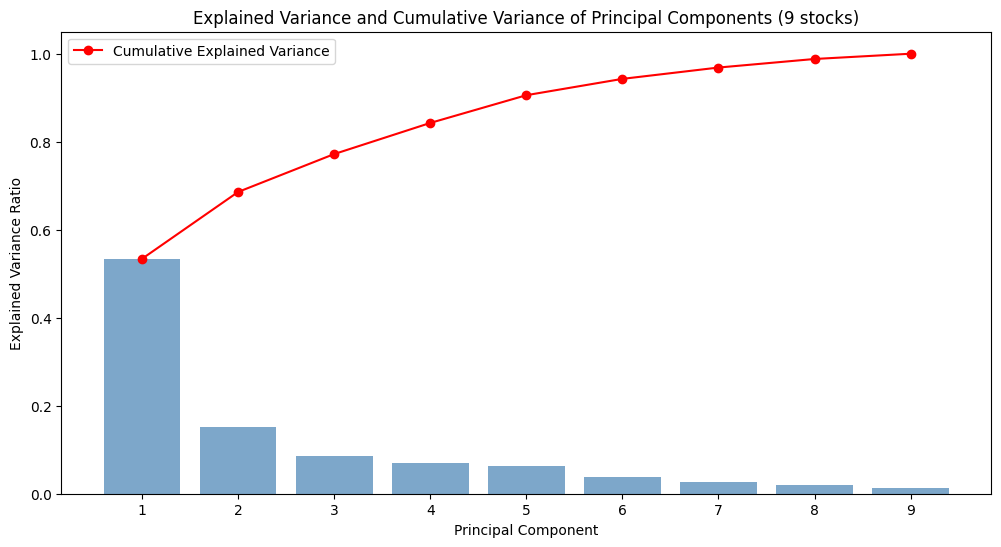

In [22]:
# Apply PCA on the log returns matrix
pca = PCA(n_components=9)  # We have 9 stocks, so we keep 9 components

# Fit the PCA model
pca.fit(log_returns)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratio for each component
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, color='steelblue')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', color='red', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance and Cumulative Variance of Principal Components (9 stocks)')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.show()


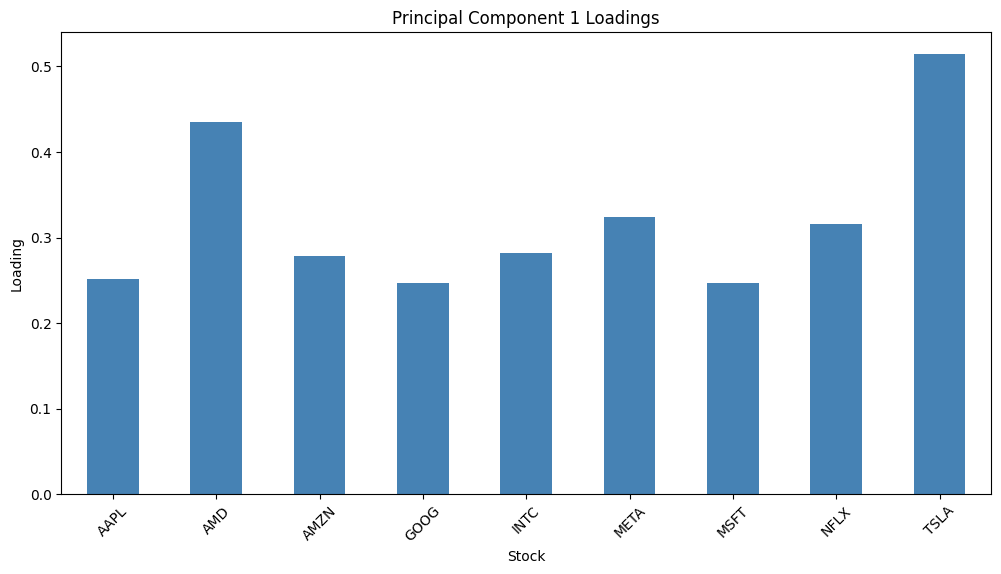

In [23]:
# Principal Component Loadings
pca_loadings = pca.components_

# Create a DataFrame for better readability
loadings_df = pd.DataFrame(pca_loadings.T, columns=[f"PC{i+1}" for i in range(len(pca_loadings))], index=log_returns.columns)

# Plot the first principal component loadings
plt.figure(figsize=(12, 6))
loadings_df['PC1'].plot(kind='bar', color='steelblue')
plt.xlabel('Stock')
plt.ylabel('Loading')
plt.title('Principal Component 1 Loadings')
plt.xticks(rotation=45)

plt.show()

# Optionally, you can plot the loadings of other principal components as well.

In [24]:
#Construct residuals (unexplained returns)
# Reconstruct the part of returns explained by PC1
pc1 = pca.components_[0]         # First principal component
scores_pc1 = pca.transform(log_returns)[:, 0]  # Projection of returns onto PC1

# Rebuild the PC1-based return matrix (outer product of scores and component)
explained_by_pc1 = np.outer(scores_pc1, pc1)

# Convert to DataFrame for easy comparison
explained_df = pd.DataFrame(explained_by_pc1, index=log_returns.index, columns=log_returns.columns)

# Residual = Actual return - return explained by PC1
residuals = log_returns - explained_df
residuals.head()


Ticker,AAPL,AMD,AMZN,GOOG,INTC,META,MSFT,NFLX,TSLA
Date,,,,,,,,,
2019-01-03,-0.071199,-0.041073,0.011669,0.004113,-0.018868,0.013963,-0.004471,0.055342,0.036863
2019-01-04,-0.004093,0.029047,-0.001821,0.007466,0.008226,-0.013045,0.000536,0.035360,-0.037589
2019-01-07,-0.024200,0.041458,0.009518,-0.023676,-0.019924,-0.027572,-0.020232,0.030507,0.008085
2019-01-08,0.010979,-0.004935,0.007749,-0.000379,-0.002536,0.021757,-0.000512,0.005622,-0.014971
2019-01-09,0.016094,-0.028646,0.000890,-0.002236,0.004806,0.010897,0.013469,-0.001901,0.007916


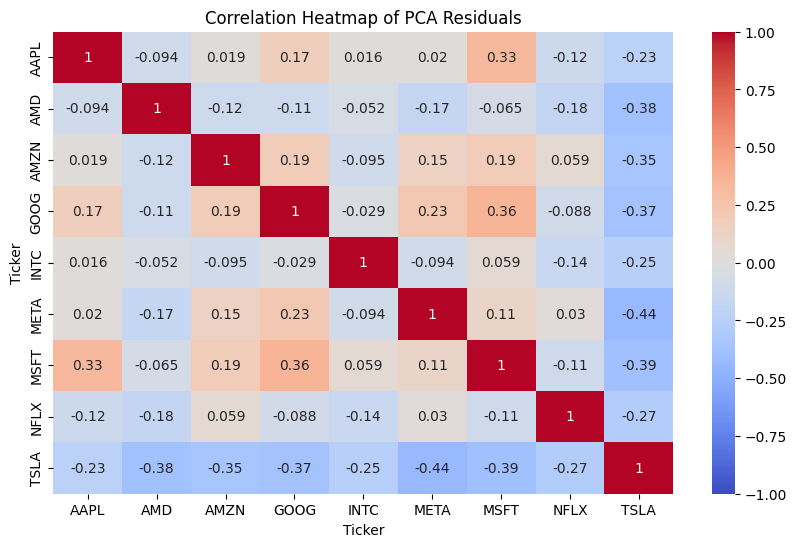

In [25]:
# Plot heatmap of residual correlations
plt.figure(figsize=(10, 6))
sns.heatmap(residuals.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of PCA Residuals')
plt.show()


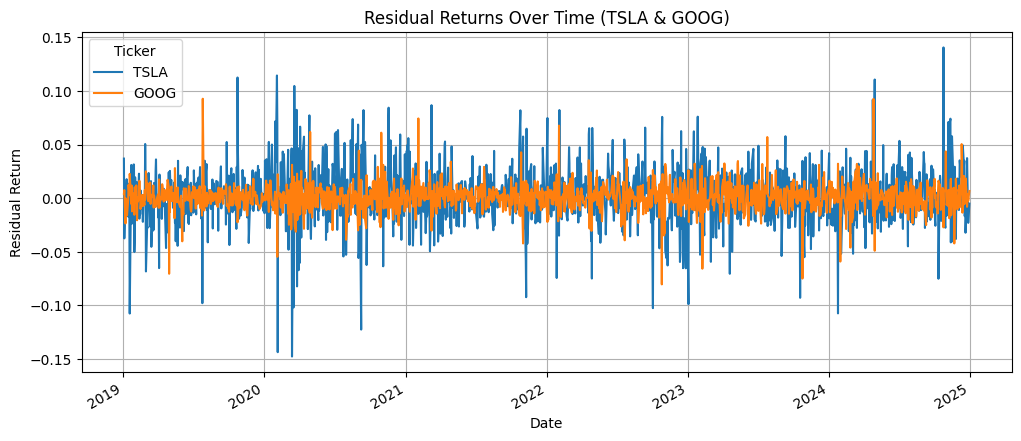

In [26]:
# Plot residuals of a few stocks
residuals[['TSLA', 'GOOG']].plot(figsize=(12, 5))
plt.title('Residual Returns Over Time (TSLA & GOOG)')
plt.xlabel('Date')
plt.ylabel('Residual Return')
plt.grid(True)
plt.show()

In [27]:
#Generate Mean-Reversion Trading Signals
# Parameters
lookback = 20
entry_threshold = 1.0
exit_threshold = 0.5

# Calculate rolling mean and std of residuals
rolling_mean = residuals.rolling(window=lookback).mean()
rolling_std = residuals.rolling(window=lookback).std()

# Z-scores
z_scores = (residuals - rolling_mean) / rolling_std

# Signal generation
signals = pd.DataFrame(index=residuals.index, columns=residuals.columns)

signals[z_scores > entry_threshold] = -1  # short
signals[z_scores < -entry_threshold] = 1  # long
signals[(z_scores.abs() < exit_threshold)] = 0  # exit

# Forward-fill positions until exit
positions = signals.ffill().fillna(0)
#positions = signals.ffill().fillna(0).infer_objects(copy=False)


positions.tail()


C:\Users\anshr\AppData\Local\Temp\ipykernel_17812\1164856500.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  positions = signals.ffill().fillna(0)


Ticker,AAPL,AMD,AMZN,GOOG,INTC,META,MSFT,NFLX,TSLA
Date,,,,,,,,,
2024-12-23,1.0,-1.0,1.0,0.0,-1.0,1.0,1.0,1.0,0.0
2024-12-24,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.0
2024-12-26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2024-12-27,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2024-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0


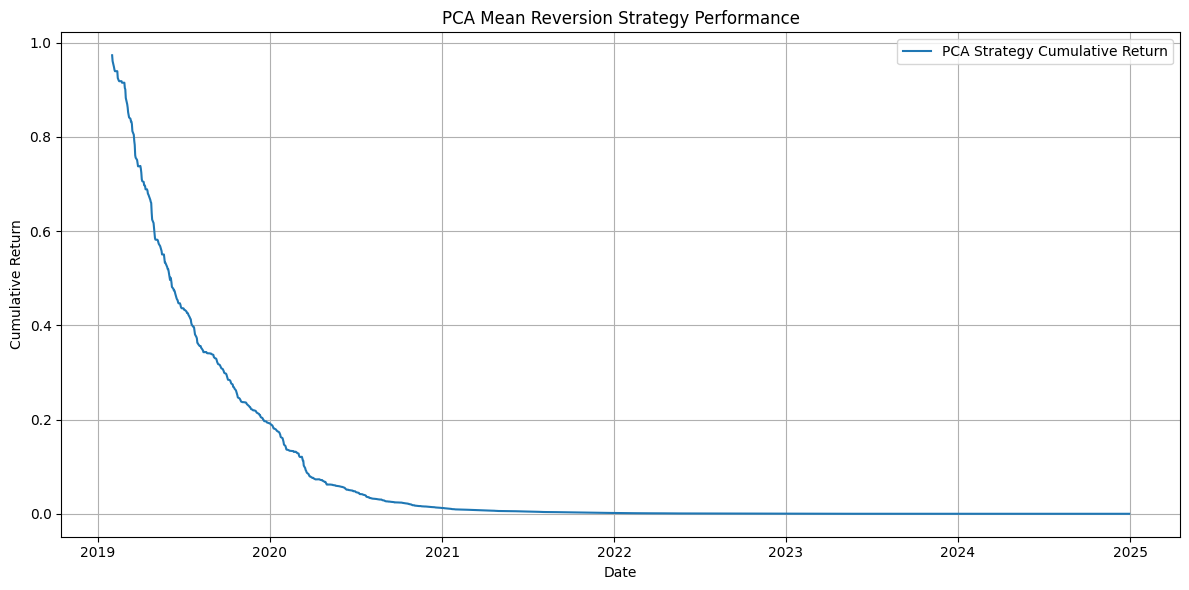

In [28]:
#Backtest the PCA Strategy
# Calculate actual daily returns for each stock
stock_returns = log_returns.copy()

# Align signals with returns (in case there’s any shift needed)
signals = signals.loc[stock_returns.index]

# Daily strategy return = mean of (signal * stock return) across all stocks per day
strategy_returns = (signals * stock_returns).mean(axis=1)

# Cumulative return over time
cumulative_returns = (1 + strategy_returns).cumprod()

# Plot equity curve
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='PCA Strategy Cumulative Return')
plt.title('PCA Mean Reversion Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
#performance metrics

# Daily strategy returns
strategy_returns_pca = positions.shift(1) * log_returns  # Shift to avoid lookahead bias
strategy_returns_pca = strategy_returns_pca.sum(axis=1)  # Sum of all active positions' returns

# Cumulative returns
cumulative_returns_pca = (1 + strategy_returns_pca).cumprod()

# Total Return
total_return_pca = cumulative_returns_pca.iloc[-1] - 1

# Annualized Return
annual_return_pca = strategy_returns_pca.mean() * 252

# Annualized Volatility
annual_volatility_pca = strategy_returns_pca.std() * np.sqrt(252)

# Sharpe Ratio
sharpe_ratio_pca = annual_return_pca / annual_volatility_pca

# Max Drawdown
rolling_max_pca = cumulative_returns_pca.cummax()
drawdown_pca = (cumulative_returns_pca - rolling_max_pca) / rolling_max_pca
max_drawdown_pca = drawdown_pca.min()

# Print metrics
#print("PCA-Based Mean Reversion Strategy Performance:")
print(f"Total Return: {total_return_pca:.2%}")
print(f"Annualized Return: {annual_return_pca:.2%}")
print(f"Annualized Volatility: {annual_volatility_pca:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_pca:.2f}")
print(f"Maximum Drawdown: {max_drawdown_pca:.2%}")

Total Return: -70.11%
Annualized Return: 13.84%
Annualized Volatility: 81.99%
Sharpe Ratio: 0.17
Maximum Drawdown: -89.54%


In [30]:
#Performance Evaluation and Comparision

In [31]:
import pandas as pd

# Metrics for Pairs Trading
pairs_metrics = {
    'Total Return': 0.5681,
    'Annualized Return': 0.1428,
    'Annualized Volatility': 0.2213,
    'Sharpe Ratio': 0.65,
    'Max Drawdown': -0.2489
}

# Metrics for PCA-Based Strategy
pca_metrics = {
    'Total Return': -0.7011,
    'Annualized Return': 0.1384,
    'Annualized Volatility': 0.8199,
    'Sharpe Ratio': 0.17,
    'Max Drawdown': -0.8954
}

# Create DataFrame
performance_df = pd.DataFrame([pairs_metrics, pca_metrics], index=['Pairs Trading', 'PCA Strategy'])

# Display nicely formatted
performance_df.style.format({
    'Total Return': '{:.2%}',
    'Annualized Return': '{:.2%}',
    'Annualized Volatility': '{:.2%}',
    'Sharpe Ratio': '{:.2f}',
    'Max Drawdown': '{:.2%}'
})

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
Pairs Trading,56.81%,14.28%,22.13%,0.65,-24.89%
PCA Strategy,-70.11%,13.84%,81.99%,0.17,-89.54%


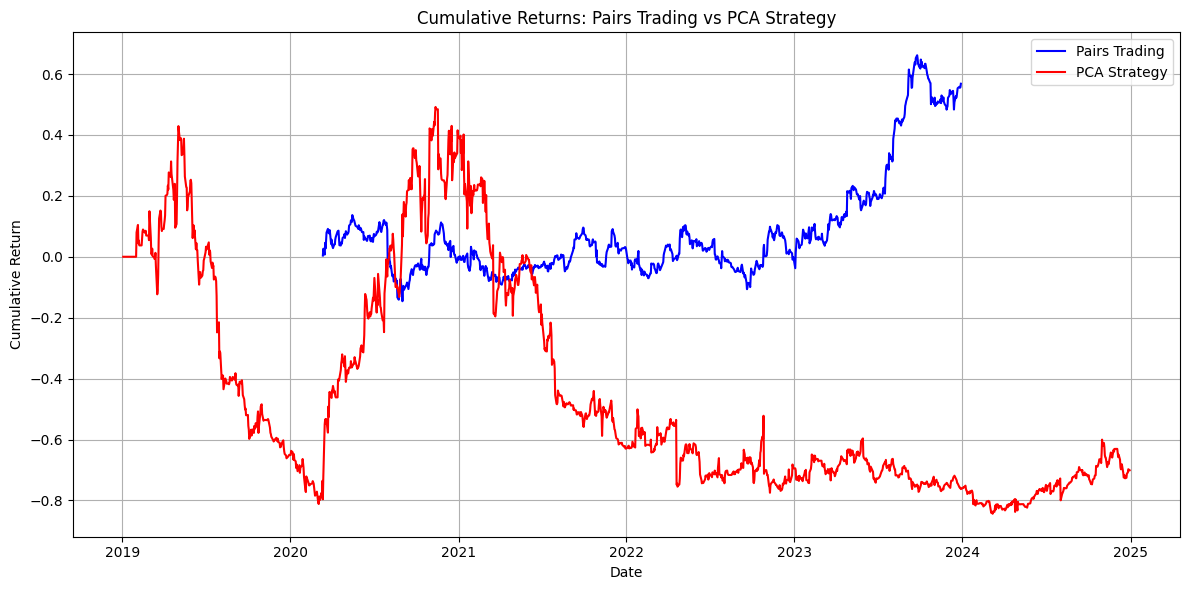

In [32]:
import matplotlib.pyplot as plt

# Plot both strategies
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns_pairs.index, cumulative_returns_pairs - 1, label='Pairs Trading', color='blue')
plt.plot(cumulative_returns_pca.index, cumulative_returns_pca - 1, label='PCA Strategy', color='red')

plt.title('Cumulative Returns: Pairs Trading vs PCA Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


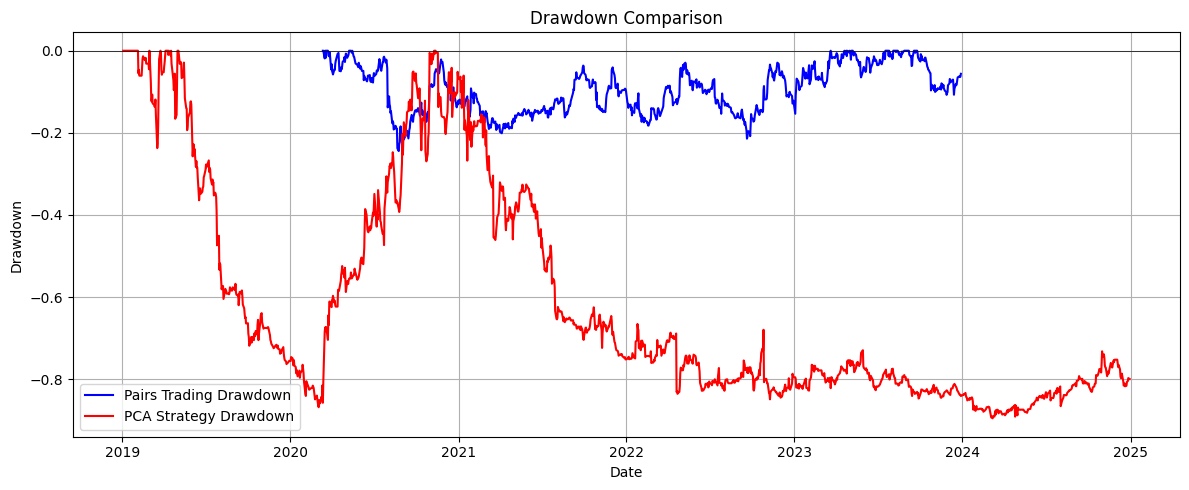

In [33]:
#Plot drawdowns

plt.figure(figsize=(12, 5))
plt.plot(drawdown, label='Pairs Trading Drawdown', color='blue')
plt.plot(drawdown_pca, label='PCA Strategy Drawdown', color='red')
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Drawdown Comparison')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()